# Chapter Filtering

In [1]:
import sys
sys.path.append('/home/commun/tp-morpho/')
from tp_init import *

## Alternate filter (AF) and alternate sequential filter (ASF)

The figures below compare the result of an alternate filter (AF) with an alternate sequential filter (ASF) of equivalent size. It can be seen that, in exchange of a higher computational cost, ASF obtain less noisy results than AF.


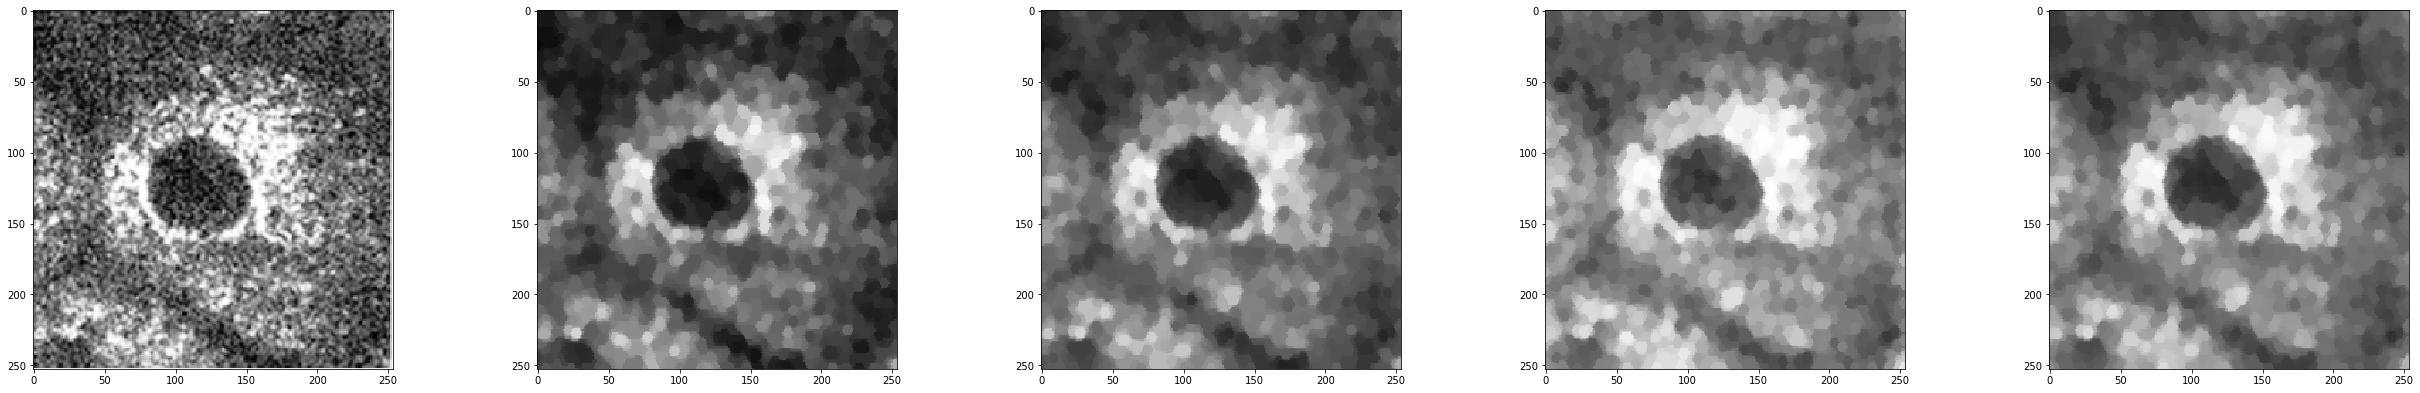

Size 3: Original, AF OpFirst, ASF OpFirst, AF ClFirst, ASF ClFirst
-----------------------------------------------


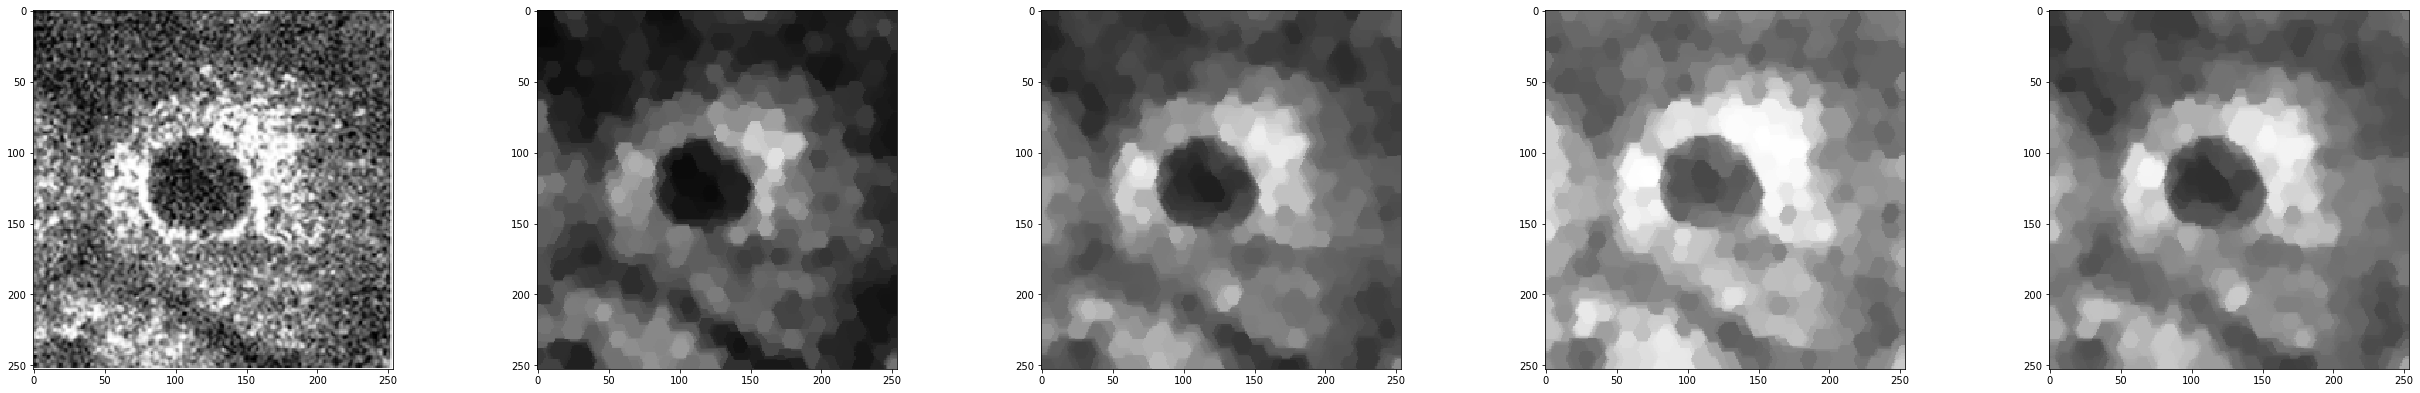

Size 5: Original, AF OpFirst, ASF OpFirst, AF ClFirst, ASF ClFirst
-----------------------------------------------


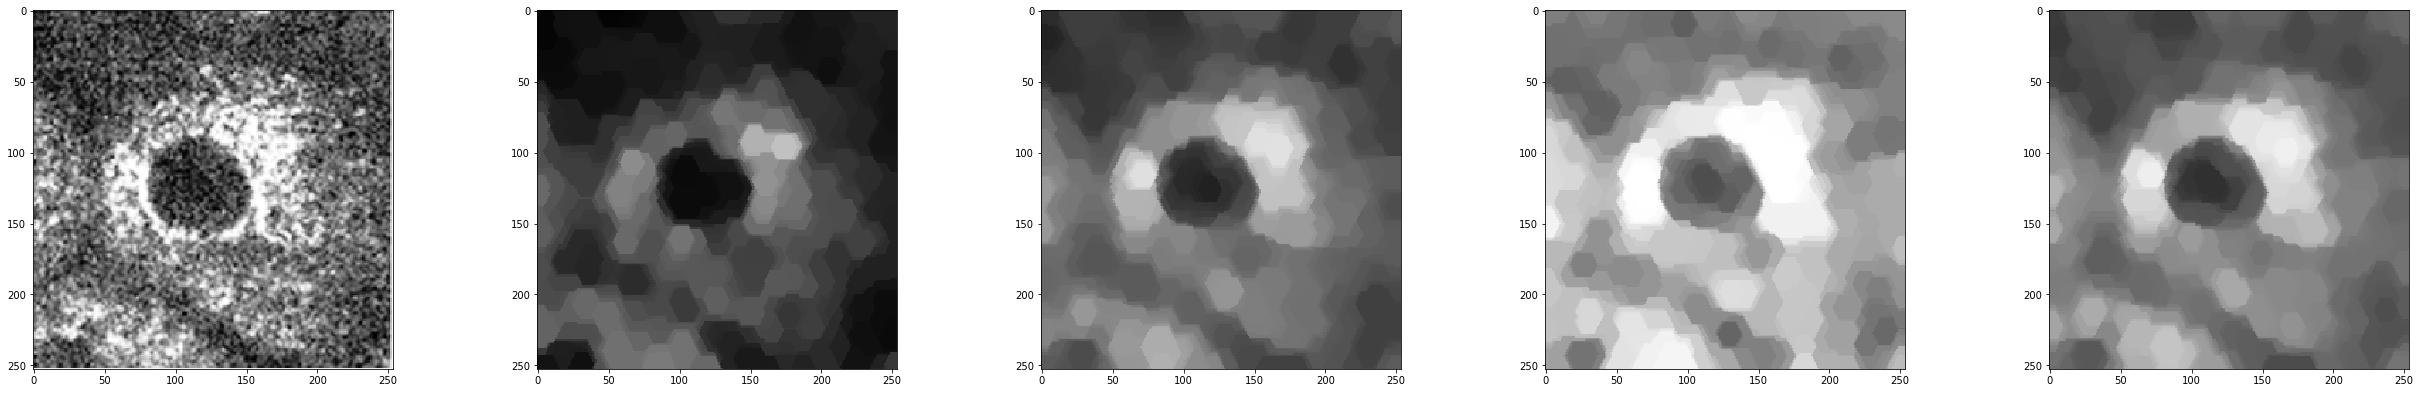

Size 8: Original, AF OpFirst, ASF OpFirst, AF ClFirst, ASF ClFirst
-----------------------------------------------


In [4]:
def AF(imIn, imOut,nl,size, firstApply = 'OF'): # for "Open First"
    imTmp = Image(imIn)
    if firstApply == 'OF':
        open(imIn,imTmp,nl(size))
        close(imTmp,imOut,nl(size))
    else:
        close(imIn,imTmp,nl(size))
        open(imTmp,imOut,nl(size))

        
def ASF(imIn, imOut,nl,size, firstApply = 'OF'):
    imTmp = Image(imIn)
    copy(imIn,imOut)
    for i in range(size):
        if firstApply == 'OF':
            open(imOut,imTmp,nl(i+1))
            close(imTmp,imOut,nl(i+1))
        else:
            close(imOut,imTmp,nl(i+1))
            open(imTmp,imOut,nl(i+1))
        

nl = HexSE()
#imIn= Image(images_dir+"/Gray/circus.png")
imIn= Image(images_dir+"/Gray/keratinocyte_crop.png")

   
#Init images
imAF1, imAF2, imASF1, imASF2 = Image(imIn),Image(imIn),Image(imIn),Image(imIn)
firstApply = 'OF'#'OF' # 'CF'

#Altertane Filter size 1
sz1 = 3
AF(imIn,imAF1,nl,sz1, firstApply = 'OF')
AF(imIn,imAF2,nl,sz1, firstApply = 'CF')
ASF(imIn,imASF1,nl,sz1, firstApply = 'OF')
ASF(imIn,imASF2,nl,sz1, firstApply = 'CF')
disp([imIn,imAF1,imASF1, imAF2, imASF2], figsize = (20, 12))
print('Size '+str(sz1)+': Original, AF OpFirst, ASF OpFirst, AF ClFirst, ASF ClFirst')
print('-----------------------------------------------')
   
#Altertane Filter size 2
sz2 = 5
AF(imIn,imAF1,nl,sz2, firstApply = 'OF')
ASF(imIn,imASF1,nl,sz2, firstApply = 'OF')
AF(imIn,imAF2,nl,sz2, firstApply = 'CF')
ASF(imIn,imASF2,nl,sz2, firstApply = 'CF')
disp([imIn,imAF1,imASF1, imAF2, imASF2], figsize = (20, 12))
print('Size '+str(sz2)+': Original, AF OpFirst, ASF OpFirst, AF ClFirst, ASF ClFirst')
print('-----------------------------------------------')

#Altertane Filter size 3
sz3 = 8
AF(imIn,imAF1,nl,sz3, firstApply = 'OF')
ASF(imIn,imASF1,nl,sz3, firstApply = 'OF')
AF(imIn,imAF2,nl,sz3, firstApply = 'CF')
ASF(imIn,imASF2,nl,sz3, firstApply = 'CF')
disp([imIn,imAF1,imASF1, imAF2, imASF2], figsize = (20, 12))
print('Size '+str(sz3)+': Original, AF OpFirst, ASF OpFirst, AF ClFirst, ASF ClFirst')
print('-----------------------------------------------')

The ASF produces slightly smoother results, but the main difference here is the lower dependence in the choice of the first operator (opening or closing).

## Levelings characterization

<img src="../illustrations/leveling_characterization.png" width="300px">

## Implementing the constrained levelings using parallel algorithm

<img src="../illustrations/leveling_illustration.png" width="300px">

Let $h$ be the marker image and $f$ the reference image. The leveling of $h$ constrained by $f$ ($g=\Lambda(h,f)$) can be obtained using primitive morphological operators in the following way:

1. copy the marker image ($h$) into the output image $g$ ($g=h;$)

2. modify g according to the following formula $[g = (f \wedge  \delta_{B} (g)) \vee \epsilon_{B} (g)] $ and iterate it until $g$ converges.

In [15]:
def flatLeveling(imMark,imIn,  imOut, nl):
    
    imTemp,imDilate,imErode,imInf,imSup = Image(imMark),Image(imMark),Image(imMark),Image(imMark),Image(imMark)

    copy(imMark, imTemp)
    compteur = 0
    cvg = False
    
    while not cvg :
        compteur+=1
        dilate(imTemp, imDilate,nl)
        erode(imTemp,  imErode,nl)
        inf(imIn, imDilate, imInf)
        sup(imInf, imErode, imSup)
        if (equ(imSup, imTemp)):
            print ("identical images")
            cvg = True
        else:
            copy(imSup, imTemp)
            copy(imSup, imOut)
    print ("flatLeveling converges in ", compteur, "iterations")


identical images
flatLeveling converges in  412 iterations


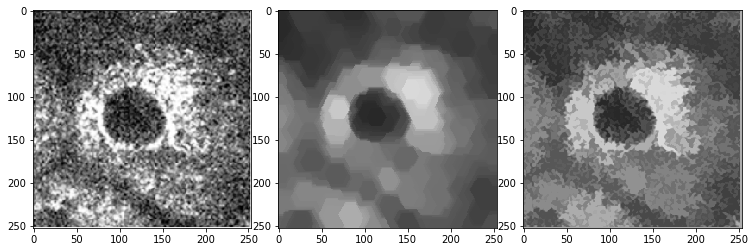

original image, marker image and corresponding constrained leveling


In [16]:
#im = Image(images_dir+"/Gray/arearea.png")
im = Image(images_dir+"/Gray/keratinocyte_crop.png")
imMark = Image(im)
imLev=Image(im)
# Marker (AF, ASF...)
szMk = 10
ASF(im, imMark,nl,szMk, firstApply = 'OF')
flatLeveling(imMark,im,imLev,nl)
disp([im,imMark,imLev])
print("original image, marker image and corresponding constrained leveling")


## Extended Levelings

In [12]:
def quasiFlatDilate(im, lamb, imDilate, nl):
    imT = Image(im)
    dilate(im, imDilate,nl)
    sub(imDilate, lamb, imT)
    sup(im, imT, imDilate)
    
def quasiFlatErode(im, lamb, imErode, nl):
    imT = Image(im)
    erode(im, imErode,nl)
    add(imErode, lamb, imT)
    inf(im, imT, imErode)
    

def lambdaLeveling( imMark,imIn, lamb, imOut,nl):
    imTemp,imDilate,imErode,imInf,imSup = Image(imMark),Image(imMark),Image(imMark),Image(imMark),Image(imMark)
    imT = Image(imMark)

    copy(imMark, imTemp)
    compteur = 0
    cvg = False
    
    while not cvg :
        compteur+=1
        quasiFlatDilate(imTemp, lamb, imDilate, nl)
        quasiFlatErode(imTemp, lamb, imErode, nl)

        inf(imIn, imDilate, imInf)
        sup(imInf, imErode, imSup)
        if (equ(imSup, imTemp)):
            print ("images identiques")
            cvg = True
        else:
            copy(imSup, imTemp)
            copy(imSup, imOut)
    print ("lambdaLeveling converge in ", compteur,"iterations")

            


In [13]:
def alpha(im, imDilate, nl):
    imT, imOpen = Image(im), Image(im)
    open(im, imOpen,nl)
    dilate(imOpen, imT,nl)
    sup(im, imT, imDilate)
    
def beta(im, imErode, nl):
    imT, imClose = Image(im), Image(im)
    close(im, imClose,nl)
    erode(imClose, imT,nl)
    inf(im, imT, imErode)

def rhoLeveling(imMark, imIn, imOut,nl):
    
    imTemp,imDilate,imErode,imInf,imSup = Image(imMark),Image(imMark),Image(imMark),Image(imMark),Image(imMark)
    imT = Image(imMark)
    imOpen, imClose = Image(imTemp),Image(imTemp)
    
    copy(imMark, imTemp)
    compteur = 0
    cvg = False
    
    
    while not cvg:
        compteur+=1
        alpha(imTemp, imDilate, nl)
        beta(imTemp, imErode, nl)
        
        inf(imIn, imDilate, imInf)
        sup(imInf, imErode, imSup)
        if (equ(imSup, imTemp)):
            print ("images identiques")
            cvg = True
        else:
            copy(imSup, imTemp)
            copy(imSup, imOut)
    print ("rhoLeveling converge in ", compteur,"iterations")
    

identical images
flatLeveling converges in  129 iterations
images identiques
lambdaLeveling converge in  121 iterations
images identiques
rhoLeveling converge in  98 iterations


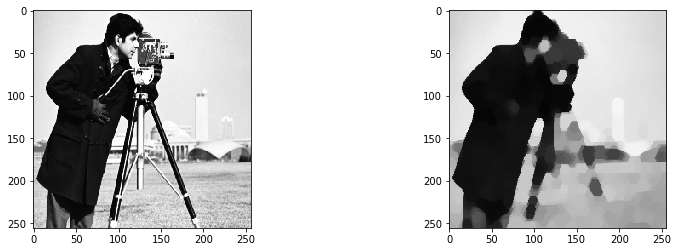

original image and marker image


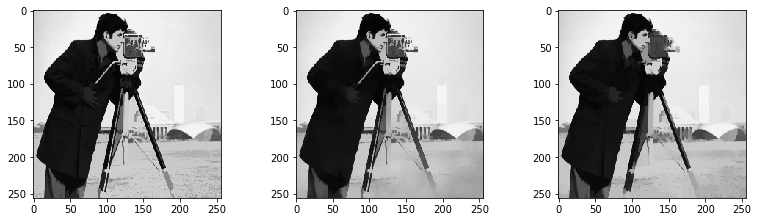

flat Leveling, lambda Leveling, Rho Leveling


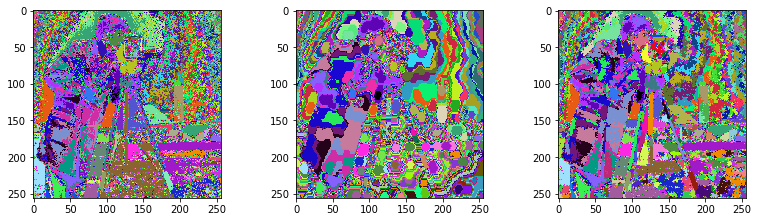

flat Leveling, lambda Leveling, Rho Leveling


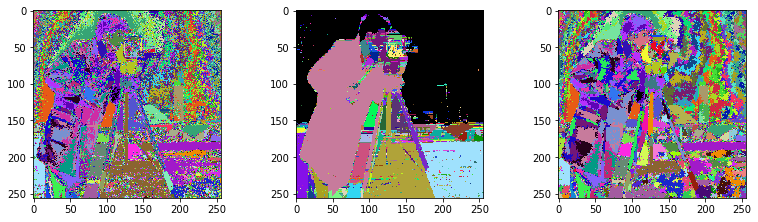

flat Leveling, lambda Leveling, Rho Leveling


In [14]:
im = Image(images_dir+"/Gray/cameraman.png")
imMark = Image(im)
imLev,imLambdaLev,imRhoLev=Image(im),Image(im),Image(im)
# AF
open(im,imMark,nl(5))
close(imMark,imMark,nl(5))

lambdaval = 1
flatLeveling(imMark,im,imLev,nl)
lambdaLeveling(imMark,im,lambdaval,imLambdaLev,nl)
rhoLeveling(imMark,im,imRhoLev,nl)

imLab =Image(imLev, "UINT16")
lambdaLabel(imLambdaLev, lambdaval, imLab,nl) 

disp([im,imMark], figsize = (20,12))
print ("original image and marker image")
disp([imLev,imLambdaLev,imRhoLev])
print ("flat Leveling, lambda Leveling, Rho Leveling")
disp([imLev,imLambdaLev,imRhoLev],[True, True, True])
print ("flat Leveling, lambda Leveling, Rho Leveling")
disp([imLev,imLab,imRhoLev],[True, True, True])
print ("flat Leveling, lambda Leveling, Rho Leveling")

## Alternate sequential levelings

<img src="../illustrations/AF_leveling.png" width="300px">

In [ ]:
def highLeveling(immark,imref,imout,nl): 
    imtmp = Image(immark)
    erode(immark, imtmp,nl)
    sup(imtmp,imref,imtmp)
    dualBuild(imtmp,imref,imout,nl)

def lowLeveling(immark,imref,imout,nl):
    imtmp = Image()
    dilate(immark,imtmp,nl)
    inf(imtmp,imref,imtmp)
    build(imtmp,imref,imout,nl)

def ASF_Leveling(imIn, size, imOut,nl):
    #Init images
    imEro,imDil,imTmp1,imTmp2 = Image(imIn),Image(imIn),Image(imIn),Image(imIn)

    copy(imIn,imEro)
    copy(imIn,imDil)

    copy(imIn,imOut)

    #Alternate sequential leveling
    for i in range(size):
        erode(imEro,imTmp1,nl)
        copy(imTmp1,imEro)
        lowLeveling( imTmp1,imOut, imTmp2,nl)

        dilate(imDil,imTmp1,nl)
        copy(imTmp1,imDil)
        highLeveling(imTmp1, imTmp2, imOut,nl)

In [ ]:
# COMPARE ASF_LEVELING WITH STANDARD LEVELINGS
im = Image(images_dir+"/Gray/foreman.png")
im_lev = Image(im)
im_asf_lev = Image(im)
nl = HexSE()

# leveling from AF
imMark = Image(im)
filter_size = 2
AF(im, imMark, nl, filter_size)
leveling(imMark,im,im_lev,nl)

# ASF_leveling
ASF_Leveling(im,filter_size,im_asf_lev,nl)

disp([im,imMark,im_lev,im_asf_lev])
print("original image, marker image(AF2), leveling from marker, ASF_Leveling2")

# leveling from AF
imMark = Image(im)
filter_size = 5
AF(im, imMark, nl, filter_size)
leveling(imMark,im,im_lev,nl)

# ASF_leveling
ASF_Leveling(im,filter_size,im_asf_lev,nl)

disp([im,imMark,im_lev,im_asf_lev])
print("original image, marker image(AF5), leveling from marker, ASF_Leveling5")

## Leveling on colored images

There are many ways to process colored images. The approach suggested here
is to separate each color image component as a gray-scale image. Apply the
leveling with an ASF as marker in each component separately. Combine again
the color components to build the colored image.

<code>colorim = Image("....png")
imR,imG,imB = extractChannels(colorim)</code>

Process each color component (im1, im2, im3) and then compose the new
color image: <code>colorim2=combineChannels(imOutR, imOutG, imOutB)</code>

In [ ]:
%matplotlib inline
im = Image(images_dir+"Color/lena_std.png")#arearea.png")
imR,imG,imB = extractChannels(im)

disp(im)
print("Original image")
disp([imR, imG, imB])
print("The three channels of the original image (R, G, B)")

imMark, imRlev, imGlev, imBlev = Image(imR), Image(imR), Image(imR),Image(imR)
filter_size = 5

ASF(imR, imMark, nl, filter_size)
leveling(imMark,imR,imRlev,nl)

ASF(imG, imMark, nl, filter_size)
leveling(imMark,imG,imGlev,nl)

ASF(imB, imMark, nl, filter_size)
leveling(imMark,imB,imBlev,nl)

disp([imRlev, imGlev, imBlev])
print("The levelings of the three channels (R, G, B)")

im2=combineChannels(imRlev, imGlev, imBlev)
disp(im2)
print("Color leveling image")

In [ ]:
%matplotlib notebook

In [ ]:
dispI(im)

In [ ]:
dispI(im2)